In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('Project/Data/data.csv')

# Introduction

#### In finance, the variability of asset prices are uncertain, and understanding their movements is important for risk management. This project seeks to forecast next day volatility for the S&P 500 (SPY) using machine learning models. SPY is the largest and most traded Exchange Traded Fund in the US and a bellwether for forecasting stock market volatility.  

#### Volatility represents how variable the price of an asset is. High volatility results from sharp and often unexpected market moves during times of market turbulence, while low volatility is associated with a more calm market environment. In this project, the terms volatility and variance will be used interchangeably, where volatiltiy is the square root of variance (like standard deviation). The definition of (true) integrated variance is:  
#### $\int_{t-1}^{t} \sigma ^2 dt$  
#### However, this quantity is not directly observable, so instead the observable and consistent estimator realiazed variance is used instead:  
#### $\sum_{i=1}^{M} r_{t,i}^2$
#### which is the sum of intraday log-returns. 

#### The data for this project is a time-series, so for simplicity, the training set will be arbitrarily chosen as 4/1/19 - 12/31/21 and the test data will be 1/3/22 - 8/10/23 since random selection of test/train data does not make sense in a time series context. Thus, we will use 5-fold CV to examine model perfromance over the training data, then use the two best models to predict the test set.  

#### The data was obtained from an independent research project with Dr. Ludkovski and thus need not be cited. There were 8 days with missing data that were removed from the dataset:
- 12/23/19
- 12/24/19
- 12/30/19
- 12/31/19
- 2/5/21
- 2/17/21
- 1/7/22
- 4/12/22

# EDA

#### What is important to notice about volatility is that the values are HEAVILY skewed, with unlikely, extreme events making up the heavy tail of the distribution. Thus, it is important to transform these variables such that their distribution is approximately normal before centering and scaling. Shown below are the raw and transformed realized variance values. We can see that the log-transformed distribution is approximately normal, as desired.

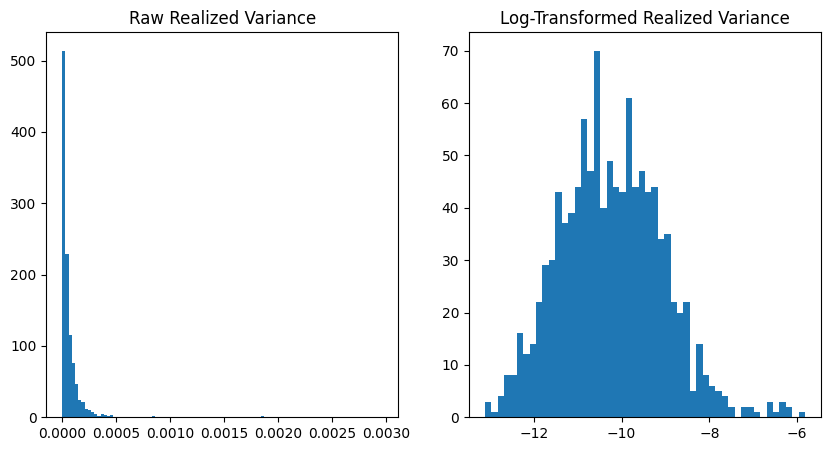

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist(data['RV_t (Realized Variance)'],bins=100)
ax[0].set_title('Raw Realized Variance')
ax[1].hist(np.log(data['RV_t (Realized Variance)']),bins=50)
ax[1].set_title('Log-Transformed Realized Variance')
plt.show()

#### Here we will log-transform all the realized variance lag variables, as well as some of the other features which have skewed distribtuions. The log-return lags are not transformed since some are very close to zero. Next, all features are centered and scaled. We can see that all features are now approximately normal and on the same scale.

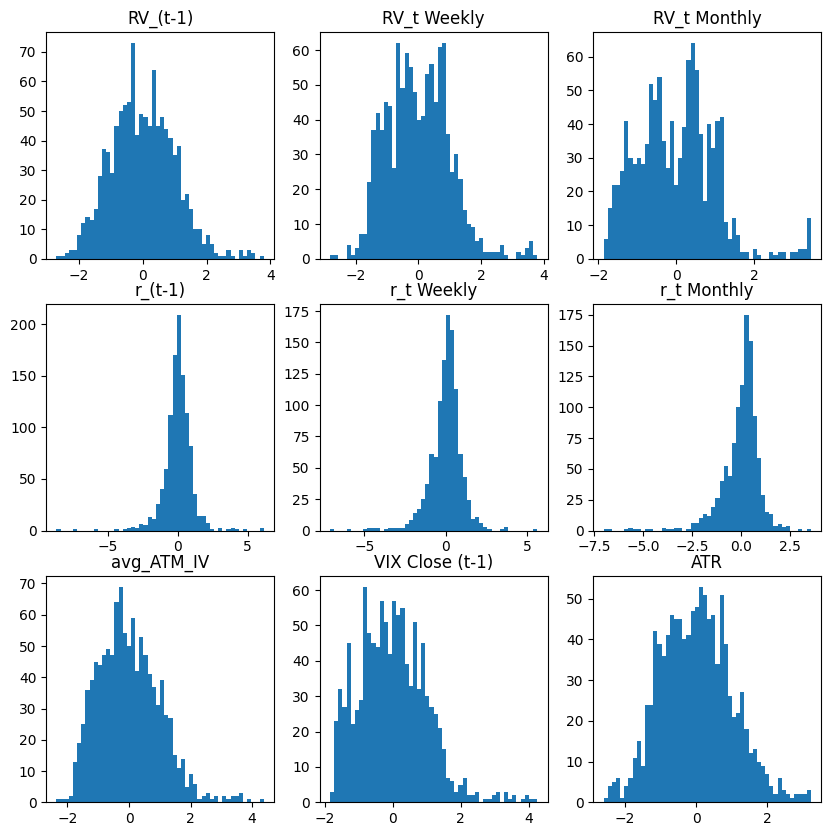

In [5]:
from sklearn.preprocessing import StandardScaler

x_transformed = pd.concat(
    [np.log(data[['RV_(t-1)', 'RV_t Weekly','RV_t Monthly']]),
    data[['r_(t-1)', 'r_t Weekly', 'r_t Monthly']],
    np.log(data[['avg_ATM_IV', 'VIX Close (t-1)', 'ATR']])
    ], axis=1)

y_transformed = pd.Series(np.log(data['RV_t (Realized Variance)']))

ss_x = StandardScaler()
ss_y = StandardScaler()
x_transformed = pd.DataFrame(ss_x.fit_transform(x_transformed), columns=x_transformed.columns)
y_transformed = pd.Series(ss_y.fit_transform(np.array(y_transformed).reshape(-1, 1)).flatten(), name=y_transformed.name)

fig, ax = plt.subplots(3,3, figsize=(10,10))
ax = ax.flatten()

for j in range(9):
    ax[j].hist(x_transformed[x_transformed.columns[j]],bins=50)
    ax[j].set_title(f"{x_transformed.columns[j]}")

#### Another important aspect of this dataset is the high correlation between features. This suggests that a regularization method (elastic net) or methods that restrict the feature set (random forest and boosted trees) could improve performance.

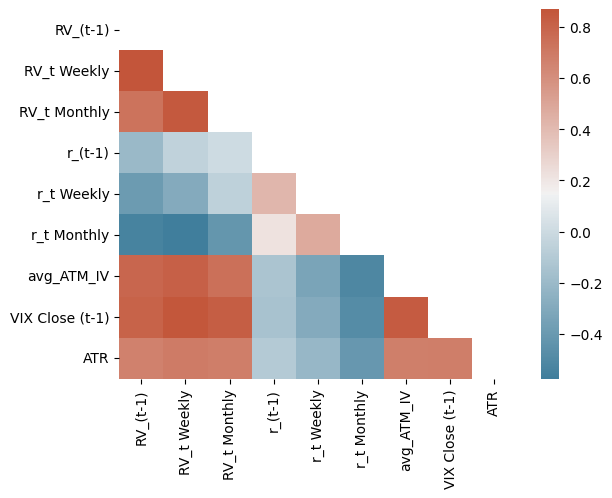

In [6]:
corr = x_transformed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap)
plt.show()

# Model setup and tuning

### **Hyperparameters**
##### Elastic Net:
- l1_ratio: The mixture of l1 and l2 regularization. A ratio of zero is pure ridge regression, and a ratio of one is pure lasso regression.  
- Alpha: The regularization strength. An Alpha of zero becomes multiple linear regression with no regularization. Higher values of alpha will penalize more severely for large $\beta$ values.  
  
##### Random Forest:
- max_features: The max number of features each tree can use to split the feature space. Lower values reduce correlation between trees.
- max_depth: The maxmimum number of consecutive splits allowed in a tree. Lower values can reduce overfitting.
- min_samples_leaf: The minimum number of samples required to be in a terminal node. Larger values can reduce overfitting.  
  
##### Gradient Boosted Trees:
- learning_rate: The contribution of each tree to the output, with values in (0,1]. A lower value will generally improve performance but requires more total trees (fixed at 1000 here).
- max_depth: Same as random forest. However, trees depth in gradient boosting is generally restricted more than in random forest.
- min_samples_leaf: Same as random forest.
- max_features: Same as random forest.

In [7]:
params_elastic_net = {
    'l1_ratio': [.01, 1/9, 2/9, 3/9,4/9,5/9,6/9,7/9,8/9,1], 
    'alpha': [i*.2 for i in range(1,11)]}

params_rf = {'max_features': [1,3,6,9],
             'max_depth': [4,8,12,16],
             'min_samples_leaf': [3,5,9,17]}

params_gb = {'learning_rate': [.1, .05, .02, .01],
             'max_depth': [4, 6],
             'min_samples_leaf': [3, 5, 9, 17],
             'max_features': [1, .3, .1]}

### **Data Split / Cross Validation / Model Tuning**

#### Now we will split the data as discussed in the intro, setup stratified k-fold crossvalidation (stratified on quantiles of the output), and tune the models.

In [8]:
np.random.seed(10)

# Split data into training and testing portions
x_train = x_transformed.iloc[:690]
x_test = x_transformed.iloc[690:]
y_train = y_transformed.iloc[:690]
y_test = y_transformed.iloc[690:]

x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

skf = StratifiedKFold(n_splits=5, shuffle=True)

# Obtain the indicies with which to perform 5-fold cross validation
indicies = []
for train_index, test_index in skf.split(x_train, 
                                         pd.qcut(
                                             y_train, q=5, labels=False # This stratifies the folds 
                                         )):                            # on quantiles of the output
    indicies.append(
        (train_index, test_index)
    )

lr = LinearRegression()
lr_cv = cross_val_score(
    estimator=lr,
    X=x_train,
    y=y_train,
    cv=indicies,
    scoring='neg_mean_squared_error')

en = ElasticNet(tol=1e-2,max_iter=10000)
grid_en = GridSearchCV(
    estimator=en,
    param_grid=params_elastic_net,
    scoring='neg_mean_squared_error',
    cv=indicies,
    verbose=1).fit(x_train,y_train)

rf = RandomForestRegressor(n_estimators=100,n_jobs=-1)
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=params_rf,
    scoring='neg_mean_squared_error',
    cv=indicies,
    verbose=1,
    n_jobs=-1).fit(x_train,y_train)

gbr = GradientBoostingRegressor(n_estimators=1000)
grid_gbr = GridSearchCV(
    estimator=gbr,
    param_grid=params_gb,
    scoring='neg_mean_squared_error',
    cv=indicies,
    verbose=1,
    n_jobs=-1).fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


### **Tuning Results**

#### Elastic Net

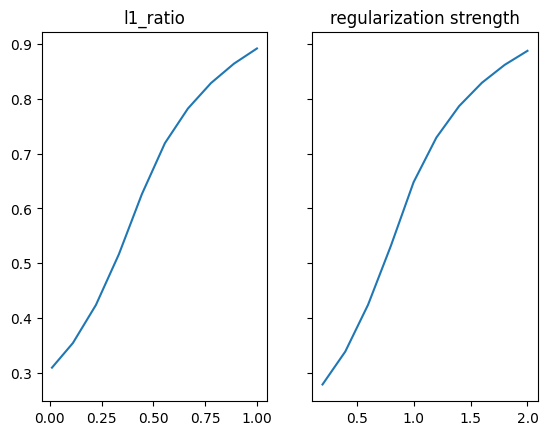

In [9]:
en_result_df = pd.DataFrame(grid_en.cv_results_)

en_result_l1, en_result_alpha = ([],[])

for l1 in params_elastic_net['l1_ratio']:
    en_result_l1.append(
        en_result_df[en_result_df['param_l1_ratio'] == l1]['mean_test_score'].mean() * -1
    )
for a in params_elastic_net['alpha']:
    en_result_alpha.append(
        en_result_df[en_result_df['param_alpha'] == a]['mean_test_score'].mean() * -1
    )

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(params_elastic_net['l1_ratio'],en_result_l1)
ax[0].set_title('l1_ratio')
ax[1].plot(params_elastic_net['alpha'],en_result_alpha)
ax[1].set_title('regularization strength')
plt.show()

##### We can see that a low value for l1_ratio and regularization strength are optimal. This suggests that a linear regression model will perform well.

#### Random Forest

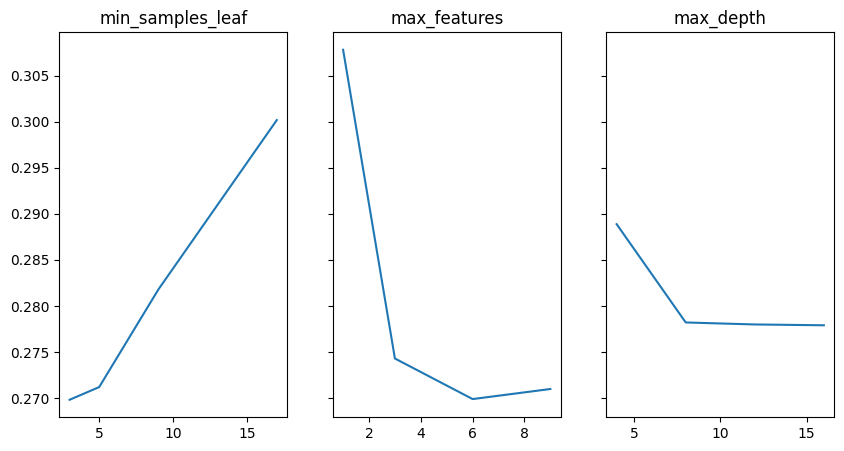

In [10]:
rf_result_df = pd.DataFrame(grid_rf.cv_results_)

rf_result_msl, rf_result_mf, rf_result_md = ([],[],[])

for msl in params_rf['min_samples_leaf']:
    rf_result_msl.append(
        rf_result_df[rf_result_df['param_min_samples_leaf'] == msl]['mean_test_score'].mean() * -1
    )
for mf in params_rf['max_features']:
    rf_result_mf.append(
        rf_result_df[rf_result_df['param_max_features'] == mf]['mean_test_score'].mean() * -1
    )
for md in params_rf['max_depth']:
    rf_result_md.append(
        rf_result_df[rf_result_df['param_max_depth'] == md]['mean_test_score'].mean() * -1
    )

fig, ax = plt.subplots(1,3, sharey=True, figsize=(10,5))
ax[0].plot(params_rf['min_samples_leaf'],rf_result_msl)
ax[0].set_title('min_samples_leaf')
ax[1].plot(params_rf['max_features'],rf_result_mf)
ax[1].set_title('max_features')
ax[2].plot(params_rf['max_depth'],rf_result_md)
ax[2].set_title('max_depth')
plt.show()

##### We see that a low value is desirable for min_samples_leaf, while moderate/higher values for max_features and max_depth improve performance. This indicates that a more flexible forest model performs best.

#### Boosted Trees

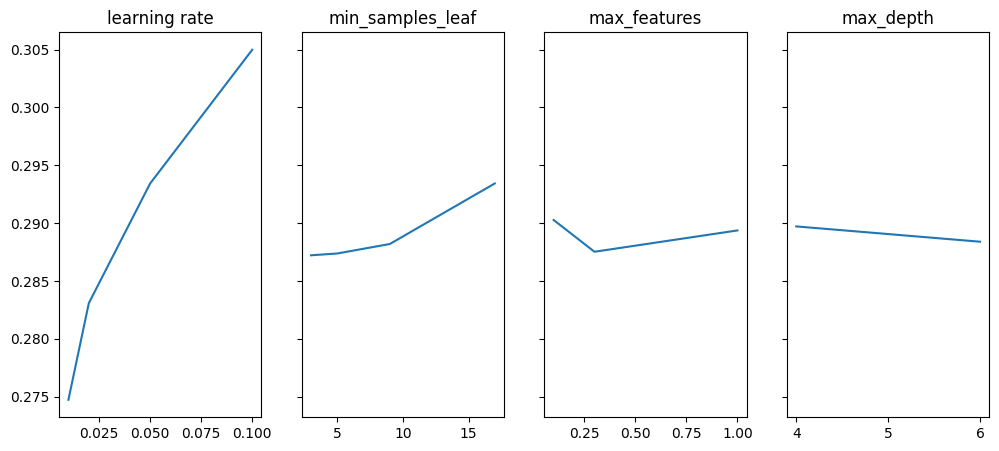

In [11]:
gbr_result_df = pd.DataFrame(grid_gbr.cv_results_)

gbr_result_lr, gbr_result_msl, gbr_result_mf, gbr_result_md = ([],[],[],[])

for lr in params_gb['learning_rate']:
    gbr_result_lr.append(
        gbr_result_df[gbr_result_df['param_learning_rate'] == lr]['mean_test_score'].mean() * -1
    )
for msl in params_gb['min_samples_leaf']:
    gbr_result_msl.append(
        gbr_result_df[gbr_result_df['param_min_samples_leaf'] == msl]['mean_test_score'].mean() * -1
    )
for mf in params_gb['max_features']:
    gbr_result_mf.append(
        gbr_result_df[gbr_result_df['param_max_features'] == mf]['mean_test_score'].mean() * -1
    )
for md in params_gb['max_depth']:
    gbr_result_md.append(
        gbr_result_df[gbr_result_df['param_max_depth'] == md]['mean_test_score'].mean() * -1
    )

fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,5))
ax[0].plot(params_gb['learning_rate'],gbr_result_lr)
ax[0].set_title('learning rate')
ax[1].plot(params_gb['min_samples_leaf'],gbr_result_msl)
ax[1].set_title('min_samples_leaf')
ax[2].plot(params_gb['max_features'],gbr_result_mf)
ax[2].set_title('max_features')
ax[3].plot(params_gb['max_depth'],gbr_result_md)
ax[3].set_title('max_depth')
plt.show()

##### We see that a low value for learning rate, and min_samples_leaf is optimal, while the other two hyperparameters do not have a large impact on model performance.

# Results

### **Cross Validation Results**

##### We now extract the results from the cross-validation evaluation of the models. NOTE: The linear regression model has no hyperparameters.

In [12]:
lr_results = {'Best Score': np.mean(lr_cv)*-1, 'Average Score': 'NA', 'Best Parameters': 'NA'}
en_results = {'Best Score': grid_en.best_score_*-1, 
              'Average Score': en_result_df['mean_test_score'].mean()*-1, 
              'Best Parameters': grid_en.best_params_}
rf_results = {'Best Score': grid_rf.best_score_*-1, 
              'Average Score': en_result_df['mean_test_score'].mean()*-1,
              'Best Parameters': grid_rf.best_params_}
gbr_results = {'Best Score': grid_gbr.best_score_*-1, 
               'Average Score': gbr_result_df['mean_test_score'].mean()*-1, 
               'Best Parameters': grid_gbr.best_params_}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

pd.DataFrame([lr_results, en_results, rf_results, gbr_results], 
             index=['Linear Regression', 'Elastic Net', 'Random Forest', 'Gradient Boosted Trees'])

,Best Score,Average Score,Best Parameters
Linear Regression,0.255788,NA,NA
Elastic Net,0.262771,0.631583,"{'alpha': 0.2, 'l1_ratio': 0.1111111111111111}"
Random Forest,0.257158,0.631583,"{'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 3}"
Gradient Boosted Trees,0.267537,0.289055,"{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 9}"


##### We see that all four models had very similar performance on the cross-validation folds. The two best, linear regression and random forest, will be further evaluated on the testing data.

In [13]:
lr = LinearRegression().fit(x_train, y_train)
rf = RandomForestRegressor(n_estimators=100, max_depth=8, max_features=6, 
                           min_samples_leaf=3).fit(x_train, y_train)
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=.01, max_depth=4,max_features=.3,min_samples_leaf=5).fit(x_train, y_train)

lr_pred, rf_pred, gbr_pred = (lr.predict(x_test), rf.predict(x_test), gbr.predict(x_test))

pd.DataFrame([mean_squared_error(lr_pred, y_test),
              mean_squared_error(rf_pred, y_test)],
              index=['Linear Regression', 'Random Forest'],
              columns=['Test Set MSE'])

,Test Set MSE
Linear Regression,0.227340
Random Forest,0.242064


##### Surprisingly, the linear model outperforms the random forest model on the test data! This has two implications. First, it seems there is a linear relationship between the transformed and scaled inputs and the next day's volatility. Second, it seems that the random forest, and the other more flexible models, overfit to their training data and were not able to perform well on unseen test data. This was already seen during the cross-validation evaluation, but further confirmed by this result.

In [14]:
yy = pd.Series(data['RV_t (Realized Variance)'])
yy_tr = yy.iloc[:690]
yy_ts = yy.iloc[690:]

pd.DataFrame([mean_squared_error(np.exp(ss_y.inverse_transform(np.array(lr_pred).reshape(-1, 1))), yy_ts),
              mean_squared_error(np.exp(ss_y.inverse_transform(np.array(rf_pred).reshape(-1, 1))), yy_ts)],
              index=['Linear Regression', 'Random Forest'],
              columns=['Test Set MSE'])

,Test Set MSE
Linear Regression,2.787665e-09
Random Forest,2.819356e-09


##### Here we tranform the predictions back to the initial scale to see if the results agree with what we obtained using the transformed and scaled data, which it does.

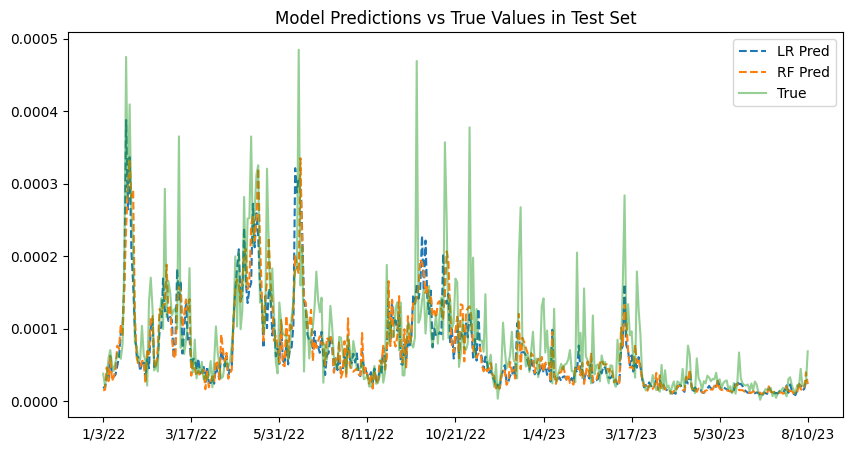

In [15]:
plt.figure(figsize=(10,5))
plt.plot(data['date'][690:], np.exp(ss_y.inverse_transform(np.array(lr_pred).reshape(-1, 1))), label='LR Pred', ls='--')
plt.plot(data['date'][690:], np.exp(ss_y.inverse_transform(np.array(rf_pred).reshape(-1, 1))), label='RF Pred', ls='--')
plt.plot(data['date'][690:], yy_ts.reset_index(drop=True), label='True', alpha=.5)
plt.xticks(data['date'][690::50])
plt.title('Model Predictions vs True Values in Test Set')
plt.legend()
plt.show()

##### We see that the models generally underpredict volatility and miss many of the sinificant spikes over this period.

##### For a linear regression model, the magnitude of the coefficients can be seen as feature importance. Thus, here are the "feature importance" values for the best model normalized:

In [25]:
feat_imp = abs(lr.coef_) / np.sum(abs(lr.coef_))

pd.DataFrame(feat_imp, index=x_train.columns, columns = ['Normalized Coefficient']).round(3)

,Normalized Coefficient
RV_(t-1),0.173
RV_t Weekly,0.006
RV_t Monthly,0.062
r_(t-1),0.001
r_t Weekly,0.042
r_t Monthly,0.015
avg_ATM_IV,0.430
VIX Close (t-1),0.064
ATR,0.207


# Conclusion

##### This project examined the ability of machine learning models to predict the next day's volatility for the SPY ETF. Surprisingly, a basic linear regression model outperformed more powerful alternatives. This indicates that there is a strong linear relationship between the scaled and transformed inputs and the next day's volatility, and that the more powerful models had overfit to their training data.  

##### It is known that "market regimes" change over long periods. Thus, a more robust model would update itself over time instead of using a fixed training window. As I examine in my own research, "rolling-window" models generally outperform fixed window models for prediction with time-series data. Rolling-window models are re-fit every day to the previous W days, which allows the model to adapt to the current market regime. This strategy is successful since data in the further past are generally less important than the recent past. To examine this idea, the same methodology of K-fold cross validation (as model selection) should be performed on the last W days to pick the best model and model hyperparameters for each day. 